# Targeted Analysis (2k Samples)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from api.text_operations import (
    clean_data,
    encode_text
)
from api.text_clustering import create_clusters

# SKLearn imports
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation

W0603 01:21:03.270577 139866499938112 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data and Cluster

In [2]:
data = pd.read_csv('sample_2000_M5_socialv3.csv')
data = data.dropna(subset=['WebSnippet'])

In [3]:
# Clean text data
clean_df = clean_data(data, mode='website')

# Get text encodings
encoding_dict = encode_text(clean_df)

Instructions for updating:
Colocations handled automatically by placer.


W0419 12:06:15.548633 4567131584 deprecation.py:323] From /Users/carlospimentel/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0419 12:06:16.794909 4567131584 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


I0419 12:06:17.069503 4567131584 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0419 12:06:19.021993 4567131584 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0419 12:06:31.653800 4567131584 session_manager.py:493] Done running local_init_op.


In [4]:
# Assemble text encodings
X = np.array([encoding_dict[r['EIN']] for _, r in clean_df.iterrows()])
print(X.shape)

(1909, 512)


In [5]:
# Dimensionality reduction (clustering)
pca_dimr = PCA(n_components=200)
X_dimr = pca_dimr.fit_transform(X)
expvar_1 = sum(pca_dimr.explained_variance_ratio_)

# Dimensionality reduction (t-SNE)
pca_tsne = PCA(n_components=70).fit(X)
X_tsne = pca_tsne.fit_transform(X)
expvar_2 = sum(pca_tsne.explained_variance_ratio_)

print('Explained variance (clustering): %.4f'%expvar_1)
print('Explained variance (t-SNE): %.4f'%expvar_2)

Explained variance (clustering): 0.9475
Explained variance (t-SNE): 0.8417


In [6]:
# Get cluster results
Z, gap_metrics, bc, clusters = create_clusters(X_dimr, C=100)

Scanning: 10
Scanning: 20
Scanning: 30
Scanning: 40
Scanning: 50
Scanning: 60
Scanning: 70
Scanning: 80
Scanning: 90
Scanning: 100

Cluster sizes: [47 49 51 52 56 58 60 62 63 65 69 70 72 73 74 75 77 78 80 81 82 83 85 86
 88 89 91 92 95 96 97 98 99]


In [7]:
# Update clean df
clean_df['cluster'] = clusters

In [22]:
clean_df['Text'][3]

'antique auto museum massachusetts larz anderson auto museum support collector car community variety educational program exhibit lecture education display upkeep major automotive collection education display upkeep major automotive collection larz anderson auto museum official site larz anderson auto museum home america oldest car collection eightyfive year larz anderson auto museum supporting community variety educational program exhibit lecturesvisitthe larz anderson auto museum faq educationexhibitsthe anderson collection anderson collection also known car coffeec ar coffee created car enthusiast meet early saturday lawn eventsoverview ince carriage german car day porsche daymembershiph elp show support preservation america oldest car collection join historylarz anderson b orn paris wealthy family raised cincinnati larz museum eventslectures join u unique experience member automotive community contacttrying reach u use list reach specific department within larz'

## Interpret Results

### t-SNE Visualization

In [8]:
# Get t-SNE embedding
X_temb = TSNE(
    n_components=2, verbose=1, perplexity=40, n_iter=500
).fit_transform(X_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1909 samples in 0.004s...
[t-SNE] Computed neighbors for 1909 samples in 0.404s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1909
[t-SNE] Computed conditional probabilities for sample 1909 / 1909
[t-SNE] Mean sigma: 0.242728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.277252
[t-SNE] KL divergence after 500 iterations: 1.458987


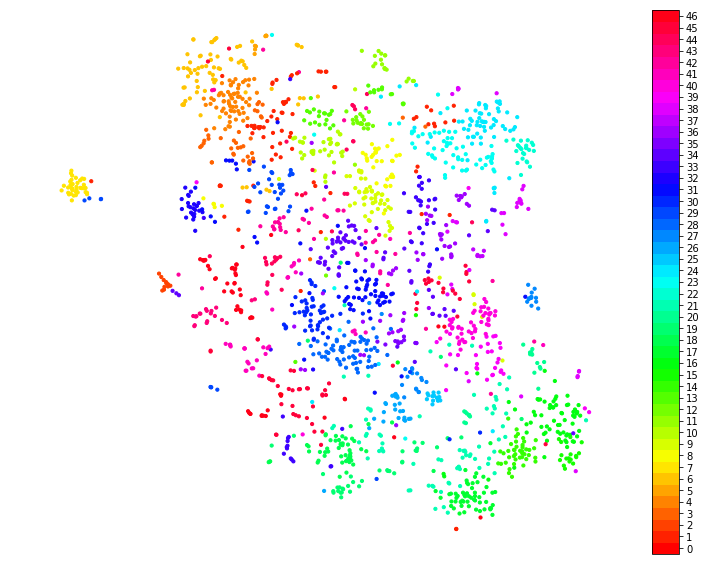

In [9]:
# Visualize t-SNE plot
vis_x = X_temb[:, 0]
vis_y = X_temb[:, 1]

plt.figure(figsize=(13, 10))
plt.axis('off')
plt.scatter(
    x=vis_x, 
    y=vis_y,
    s=10,
    c=clusters, 
    cmap=plt.cm.get_cmap('hsv', bc[0])
)
plt.colorbar(ticks=range(bc[0]+1))
plt.clim(-0.5, bc[0]-0.5)
plt.show()

### LDA Verification

In [10]:
#------------------------------------------------------------------------------#
def display_topics(model, feature_names, no_top_words):
    """
    Helper function for displaying top words of a topic
    """
    for topic_idx, topic in enumerate(model.components_):
        print('\nTopic %d:'%(topic_idx+1))
        print(' '.join([
            feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]
        ]))
    
    return None


def topic_distribution(df, X_lda, n_clusters, cluster_num):
    """
    Helper function for displaying distribution of LDA topics for a single 
    cluster
    """
    # Get indexes of topic selection
    select_df = df[df['cluster']==cluster_num].copy(deep=True)
    select_idx = select_df.index.values
    
    # Aggregate probabilties
    X_prob = X_lda[select_idx]
    X_max = np.max(X_prob)
    agg_probs = np.prod(X_prob/X_max, axis=0)
    
    # Plot probabilities
    fig, ax = plt.subplots(3, 1, figsize=(10, 21))
    ax[0].bar(
        x = np.arange(n_clusters)+1,
        height = agg_probs,
        width=0.6
    )
    ax[0].set_xticks(np.arange(1, n_clusters+1, 2))
    ax[0].set_title('LDA Topic Probabilities for Cluster %d'%cluster_num)
    ax[0].set_ylabel('Agg. Probability')
    ax[0].set_xlabel('LDA Topic Numbers')
    
    # Plot argmax distribution
    argmax = np.argmax(X_prob, axis=1)+1
    argmax_idx, argmax_cnt = np.unique(argmax, return_counts=True)
    
    x_axis = np.arange(n_clusters)+1
    y_axis = np.array([
        argmax_cnt[np.where(argmax_idx==n)[0]][0]
        if n in argmax_idx else 0
        for n in x_axis
    ])
    ax[1].bar(
        x = x_axis,
        height = y_axis,
        width=0.6
    )
    ax[1].set_xticks(np.arange(1, n_clusters+1, 2))
    ax[1].set_title('LDA Topic Counts for Cluster %d'%cluster_num)
    ax[1].set_ylabel('LDA Topic Counts')
    ax[1].set_xlabel('LDA Topic Numbers')
    
    # Probability density calculations
    prob_df = pd.DataFrame(
        data = X_prob,
        index = np.arange(len(select_idx)),
        columns = np.arange(n_clusters)
    )
    prob_df.plot.kde(legend=False, ax=ax[2])
    ax[2].set_title('Probability Density Plot for Cluster %d'%cluster_num)
    plt.show()
    
    return None
#------------------------------------------------------------------------------#

In [11]:
# Count-vectorize corpus
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
tf = tf_vectorizer.fit_transform(clean_df['Text'].values)
tf_feature_names = tf_vectorizer.get_feature_names()

In [12]:
# Run LDA
lda = LatentDirichletAllocation(
    n_components=bc[0], 
    max_iter=5,
    random_state=0
)
X_lda = lda.fit_transform(tf)

In [13]:
# Show top words of topics
display_topics(lda, tf_feature_names, 10)


Topic 1:
education school public program foundation student educational service teacher library

Topic 2:
community access center marriage business society event town people live

Topic 3:
garden hospice care texas health family free education life program

Topic 4:
health community center service education mental organization provide support training

Topic 5:
art artist center performance community program theatre exhibition work class

Topic 6:
service county washington community program youth safety provide hill local

Topic 7:
historic park valley house wine island museum tour cultural event

Topic 8:
service emergency financial provide st need member providing credit area

Topic 9:
kid san child youth foster good minnesota provide wish organization

Topic 10:
child service family center program childrens care support abuse parent

Topic 11:
water farm family catholic river program rural promote conservation well

Topic 12:
virginia law horse west police challenge university inc 

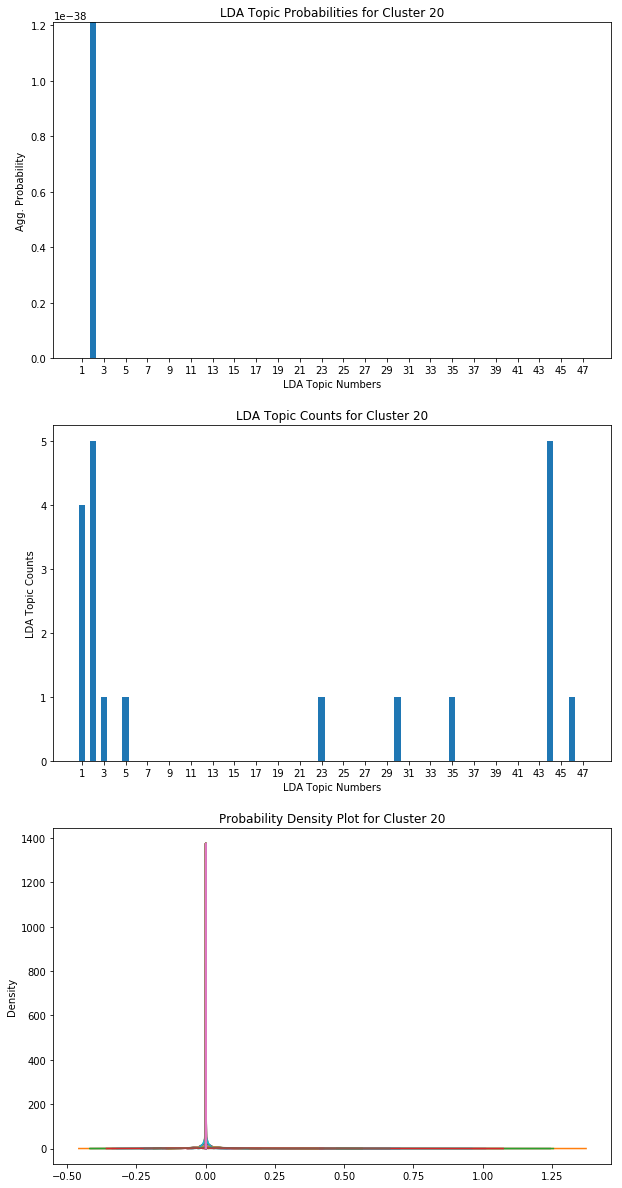

In [23]:
# Visualize topic distribution
topic_distribution(clean_df, X_lda, bc[0], 20)